# Project Northwind

Author: Tony Kelly, Weina Dai 
Date: August 5, 2024

In today's competitive market, understanding customer behavior and preferences is crucial for the success of businesses. However, the vast amounts of data generated from online transaction processing (OLTP) systems can be overwhelming and challenging to interpret. To address this, our project employs dimensional reduction and clustering techniques to simplify and group data into customer profiles, providing businesses with actionable insights to enhance their strategies.

Our project aims to empower businesses with a deeper understanding of their customer base, enabling them to make data-driven decisions that foster growth and competitiveness. The insights gained from this analysis can inform various business aspects, from product development and pricing strategies to targeted marketing campaigns and personalized customer experiences.

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# dimensional reduction and clustering
import umap.umap_ as umap
from k_means_constrained import KMeansConstrained
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import (
    KMeans,
    HDBSCAN,
    OPTICS,
    AgglomerativeClustering,
    SpectralClustering,
)

# hyperparameter optimization
import optuna

# database
import sqlite3

# utils
import traceback
from datetime import datetime
from functools import partial
from joblib import load, dump
from sklearn.preprocessing import OneHotEncoder

# Ensure matplotlib inline mode
%matplotlib inline

# Data Wrangling

To begin with, we merge multiple sources/tables, removing missing values to ensure a clean dataset.

Next, data transformation is performed to convert data into a suitable format for analysis. This involves normalizing numerical values, encoding categorical variables, and creating new features that capture essential aspects of the data. 

In [3]:
# Create a SQL connection to the Northwind database
conn = sqlite3.connect("northwind-SQLite3-main/dist/northwind.db")
cur = conn.cursor()
# Execute the query to get customer data
query = "SELECT Orders.OrderID, Orders.OrderDate, Orders.ShippedDate, Customers.Country AS CustomerCountry, Customers.City AS CustomerCity, Customers.Region AS CustomerRegion, Products.ProductID, Products.ProductName, Products.CategoryID, [Order Details].UnitPrice, [Order Details].Quantity, [Order Details].Discount, Categories.CategoryName, Suppliers.Country AS SupplierCountry, Suppliers.Region AS SupplierRegion, ([Order Details].UnitPrice * [Order Details].Quantity) - ([Order Details].UnitPrice * [Order Details].Quantity * [Order Details].Discount) AS TotalPrice FROM Orders INNER JOIN Customers ON Orders.CustomerID = Customers.CustomerID INNER JOIN [Order Details] ON Orders.OrderID = [Order Details].OrderID INNER JOIN Products ON [Order Details].ProductID = Products.ProductID INNER JOIN Categories ON Products.CategoryID = Categories.CategoryID INNER JOIN Suppliers ON Products.SupplierID = Suppliers.SupplierID WHERE Orders.OrderDate BETWEEN '2010-01-01' AND '2020-12-31' ORDER BY Orders.OrderDate"
customer_data = pd.read_sql_query(query, conn)
customer_data.to_csv("customer_data.csv")

In [3]:
customer_data.head()

,OrderID,OrderDate,ShippedDate,CustomerCountry,CustomerCity,CustomerRegion,ProductID,ProductName,CategoryID,UnitPrice,Quantity,Discount,CategoryName,SupplierCountry,SupplierRegion,TotalPrice
0,10248,2016-07-04,2016-07-16,France,Reims,Western Europe,11,Queso Cabrales,4,14.0,12,0.0,Dairy Products,Spain,Southern Europe,168.0
1,10248,2016-07-04,2016-07-16,France,Reims,Western Europe,42,Singaporean Hokkien Fried Mee,5,9.8,10,0.0,Grains/Cereals,Singapore,South-East Asia,98.0
2,10248,2016-07-04,2016-07-16,France,Reims,Western Europe,72,Mozzarella di Giovanni,4,34.8,5,0.0,Dairy Products,Italy,Southern Europe,174.0
3,10249,2016-07-05,2016-07-10,Germany,Münster,Western Europe,14,Tofu,7,18.6,9,0.0,Produce,Japan,Eastern Asia,167.4
4,10249,2016-07-05,2016-07-10,Germany,Münster,Western Europe,51,Manjimup Dried Apples,7,42.4,40,0.0,Produce,Australia,NSW,1696.0


In [4]:
def clean_data(data, cols_to_transform, cols_to_retain):
    """
    preprocesses and transforms data
    parameters:
        data: the data to process
        cols_to_transform: columns in the data to transform with a one-hot encoder
        cols_to_retain: columns in the data to retain their orignal formats
    """
    enc = OneHotEncoder(
        drop="first",
        sparse_output=False,
        min_frequency=int(data.shape[0] * 0.005),
        handle_unknown="infrequent_if_exist",
        dtype=int,
    )
    transformed = enc.fit_transform(data[cols_to_transform])
    processed_data = np.concatenate([data[cols_to_retain], transformed], axis=1)
    # save to local file
    dump(processed_data, "serialized_data.joblib", compress=9)

    return processed_data

In [5]:
cols_to_transform = [
    "OrderDate",
    "ShippedDate",
    "CustomerCountry",
    "CustomerCity",
    "CustomerRegion",
    "ProductName",
    "CategoryName",
    "SupplierCountry",
    "SupplierRegion",
]
cols_to_retain = ["TotalPrice", "UnitPrice", "Quantity", "Discount"]
preprocessed_data = clean_data(customer_data, cols_to_transform, cols_to_retain)

# Dimensionality Reduction and Clustering
Dimensional reduction methods are utilized to simplify complex datasets by reducing the number of dimesions in tabular data while preserving the essential information. Clustering techniques are then applied to segment customers into distinct groups based on shared characteristics and behaviors. This segmentation will become the basis of downstream analysis, allowing businesses to tailor their marketing, sales, and service strategies to meet the specific needs of different customer groups, leading to improved customer satisfaction and loyalty.

We will find the best combination of dimensional reduction and clustering methods by using optuna, an automatic hyperparameter optimization framework. The search space is 3x5, with three dimensionality reduction algorithms (PCA, t-SNE, UMAP) and five clustering techniques (KMeans, HDBSCAN, OPTICS, Agglomerative Clustering, Spectral Clustering).


In [6]:
def objective(trial, data):
    """
    use OPTUNA to find optimal hyperparameters for each 3 x 5 combimations of dimensionality reduction and clustering algorithm
    3 dimensionality reduction algorithms (PCA, t-SNE, UMAP) x 5 clustering techniques (KMeans, HDBSCAN, OPTICS, Agglomerative Clustering, Spectral Clustering) experimental design
    """
    reducer_name = trial.suggest_categorical("reducer", ["PCA", "t-SNE", "UMAP"])
    clusterer_name = trial.suggest_categorical(
        "clusterer", ["KMeans", "HDBSCAN", "OPTICS", "Agglomerative", "Spectral"]
    )
    reducer_n, clusterer_n = 0, 0

    if reducer_name == "PCA":

        reducer_n = trial.suggest_int("pca_n", 2, 20)
        whiten = trial.suggest_categorical("whiten", [True, False])
        solver = trial.suggest_categorical("solver", ["full", "arpack", "randomized"])
        pca_tol = trial.suggest_float("pca_tol", 0.0, 10.0)
        n_oversamples = trial.suggest_int("n_oversamples", 1, 20)
        normalizer = trial.suggest_categorical(
            "normalizer", ["auto", "QR", "LU", "none"]
        )
        reducer = PCA(
            n_components=reducer_n,
            whiten=whiten,
            svd_solver=solver,
            tol=pca_tol,
            n_oversamples=n_oversamples,
            power_iteration_normalizer=normalizer,
            random_state=99,
        )

    elif reducer_name == "t-SNE":

        tsne_method = trial.suggest_categorical("tsne_method", ["barnes_hut", "exact"])
        if tsne_method == "barnes_hut":
            reducer_n = trial.suggest_int("tsne_n", 1, 3)
        else:
            reducer_n = trial.suggest_int("tsne_n", 2, 20)
        perplexity = trial.suggest_float("perplexity", 5.0, 50.0)
        tightness = trial.suggest_float("tightness", 5.0, 20.0)
        tsne_lr = trial.suggest_float("tsne_lr", 10.0, 100.0, step=5.0)
        tsne_metric = trial.suggest_categorical(
            "tsne_metric",
            [
                "sokalsneath",
                "rogerstanimoto",
                "russellrao",
                "sokalmichener",
                "yule",
                "nan_euclidean",
                "cosine",
                "wminkowski",
                "correlation",
                "minkowski",
                "sqeuclidean",
                "chebyshev",
                "haversine",
                "dice",
                "cityblock",
                "matching",
                "seuclidean",
                "hamming",
                "l2",
                "euclidean",
                "braycurtis",
                "mahalanobis",
                "jaccard",
                "manhattan",
                "canberra",
                "l1",
            ],
        )
        tsne_init = trial.suggest_categorical("tsne_init", ["random", "pca"])
        reducer = TSNE(
            n_components=reducer_n,
            method=tsne_method,
            perplexity=perplexity,
            early_exaggeration=tightness,
            learning_rate=tsne_lr,
            metric=tsne_metric,
            init=tsne_init,
            random_state=99,
        )

    else:

        reducer_n = trial.suggest_int("umap_n", 2, 20)
        umap_n_neighbors = trial.suggest_int("umap_n_neighbors", 2, 502, step=5)
        min_dist = trial.suggest_float("min_dist", 0.0, 0.99, step=0.05)
        umap_metric = trial.suggest_categorical(
            "umap_metric",
            [
                "braycurtis",
                "canberra",
                "chebyshev",
                "correlation",
                "cosine",
                "dice",
                "euclidean",
                "hamming",
                "haversine",
                "jaccard",
                "mahalanobis",
                "manhattan",
                "minkowski",
                "rogerstanimoto",
                "russellrao",
                "seuclidean",
                "sokalmichener",
                "sokalsneath",
                "yule",
            ],
        )
        reducer = umap.UMAP(
            n_components=reducer_n,
            n_neighbors=umap_n_neighbors,
            min_dist=min_dist,
            metric=umap_metric,
        )

    if clusterer_name == "KMeans":

        clusterer_n = trial.suggest_int("kmeans_n", 2, 20)
        kmeans_init = trial.suggest_categorical("kmeans_init", ["random", "k-means++"])
        if kmeans_init == "random":
            kmeans_n_init = trial.suggest_int("kmeans_n_init", 1, 20)
        else:
            kmeans_n_init = 1
        kmeans_tol = trial.suggest_categorical(
            "kmeans_tol", [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0]
        )
        kmeans_algo = trial.suggest_categorical("kmeans_algo", ["lloyd", "elkan"])
        clusterer = KMeans(
            n_clusters=clusterer_n,
            init=kmeans_init,
            n_init=kmeans_n_init,
            tol=kmeans_tol,
            algorithm=kmeans_algo,
            random_state=99,
        )

    elif clusterer_name == "HDBSCAN":

        hdbscan_n = trial.suggest_int("hdbscan_n", 2, 502, step=5)
        clusterer_n = data.shape[0] // hdbscan_n
        min_samples = trial.suggest_int("min_samples", 2, 200, step=2)
        epsilon = trial.suggest_float("epsilon", 0.0, 10.0, step=0.1)
        hdbscan_metric = trial.suggest_categorical(
            "hdbscan_metric",
            [
                "l1",
                "l2",
                "braycurtis",
                "canberra",
                "chebyshev",
                "cityblock",
                "correlation",
                "cosine",
                "dice",
                "euclidean",
                "hamming",
                "jaccard",
                "jensenshannon",
                "mahalanobis",
                "minkowski",
                "rogerstanimoto",
                "russellrao",
                "seuclidean",
                "sokalmichener",
                "sokalsneath",
                "sqeuclidean",
                "yule",
            ],
        )
        alpha = trial.suggest_float("alpha", 0.1, 10.0, step=0.1)
        hdbscan_algo = trial.suggest_categorical(
            "hdbscan_algo", ["auto", "brute", "kd_tree", "ball_tree"]
        )
        hdbscan_leaf_size = trial.suggest_int("hdbscan_leaf_size", 10, 100, step=5)
        hdbscan_method = trial.suggest_categorical("hdbscan_method", ["eom", "leaf"])
        clusterer = HDBSCAN(
            min_cluster_size=hdbscan_n,
            min_samples=min_samples,
            cluster_selection_epsilon=epsilon,
            metric=hdbscan_metric,
            alpha=alpha,
            algorithm=hdbscan_algo,
            leaf_size=hdbscan_leaf_size,
            cluster_selection_method=hdbscan_method,
        )

    elif clusterer_name == "OPTICS":

        optics_n = trial.suggest_int("optics_n", 2, 502, step=5)
        clusterer_n = data.shape[0] // optics_n
        max_eps = trial.suggest_categorical(
            "max_eps", [1.0, 10.0, 100.0, 1000.0, 10000.0, np.inf]
        )
        optics_metric = trial.suggest_categorical(
            "optics_metric",
            [
                "cityblock",
                "cosine",
                "euclidean",
                "l1",
                "l2",
                "manhattan",
                "braycurtis",
                "canberra",
                "chebyshev",
                "correlation",
                "dice",
                "hamming",
                "jaccard",
                "mahalanobis",
                "minkowski",
                "rogerstanimoto",
                "russellrao",
                "seuclidean",
                "sokalmichener",
                "sokalsneath",
                "sqeuclidean",
                "yule",
            ],
        )
        if optics_metric == "manhattan":
            p = trial.suggest_int("p", 2, 10)
        else:
            p = 2
        optics_method = trial.suggest_categorical("optics_method", ["xi", "dbscan"])
        xi = trial.suggest_float("xi", 0.0, 1.0, step=0.05)
        optics_algo = trial.suggest_categorical(
            "optics_algo", ["auto", "ball_tree", "kd_tree", "brute"]
        )
        optics_leaf_size = trial.suggest_int("optics_leaf_size", 10, 100, step=5)
        clusterer = OPTICS(
            min_samples=optics_n,
            max_eps=max_eps,
            metric=optics_metric,
            p=p,
            cluster_method=optics_method,
            xi=xi,
            algorithm=optics_algo,
            leaf_size=optics_leaf_size,
        )

    elif clusterer_name == "Agglomerative":

        clusterer_n = trial.suggest_int("agglo_n", 2, 20)
        linkage = trial.suggest_categorical(
            "linkage", ["ward", "complete", "average", "single"]
        )
        if linkage == "ward":
            agglo_metric = "euclidean"
        else:
            agglo_metric = trial.suggest_categorical(
                "agglo_metric", ["euclidean", "l1", "l2", "manhattan", "cosine"]
            )
        clusterer = AgglomerativeClustering(
            n_clusters=clusterer_n, metric=agglo_metric, linkage=linkage
        )

    else:
        clusterer_n = trial.suggest_int("spec_cluster", 2, 20)
        spec_n = trial.suggest_int("spec_n", 2, 20)
        eigen_solver = trial.suggest_categorical(
            "eigen_solver", ["arpack", "lobpcg", "amg"]
        )
        spec_n_init = trial.suggest_int("spec_n_init", 1, 20)
        spec_gamma = trial.suggest_float("spec_gamma", 0.1, 10.0, step=0.5)
        affinity = trial.suggest_categorical(
            "affinity",
            [
                "nearest_neighbors",
                "rbf",
                "precomputed",
                "precomputed_nearest_neighbors",
            ],
        )
        spec_n_neighbors = trial.suggest_int("spec_n_neighbors", 2, 500, step=5)
        assign_labels = trial.suggest_categorical(
            "assign_lables", ["kmeans", "discretize", "cluster_qr"]
        )
        degree = trial.suggest_categorical("degree", [1.0, 2.0, 3.0, 4.0, 5.0])
        coef0 = trial.suggest_float("coef0", 0.0, 100.0)
        clusterer = SpectralClustering(
            n_clusters=clusterer_n,
            n_components=spec_n,
            eigen_solver=eigen_solver,
            n_init=spec_n_init,
            gamma=spec_gamma,
            affinity=affinity,
            n_neighbors=spec_n_neighbors,
            assign_labels=assign_labels,
            degree=degree,
            coef0=coef0,
            random_state=99,
        )

    try:
        embeddings = reducer.fit_transform(data)
        labels = clusterer.fit_predict(embeddings)
        score = silhouette_score(embeddings, labels)
        return score

    except Exception as e:
        print(
            f"Error with combination: {reducer} (n_components={reducer_n}), {clusterer} (n_clusters={clusterer_n})"
        )
        print(traceback.format_exc())
        return -1  # Return a bad score if an error occurs

In [ ]:
# Create a study session
study = optuna.create_study(direction="maximize")

# Perform the study
study.optimize(partial(objective, data=preprocessed_data), n_trials=500)

# Print the best parameters and the best score
print(study.best_trial)
print("Best score:", study.best_value)
print("Best params:", study.best_params)

# Save study as a dataframe
session = study.trials_dataframe()
session.to_csv("session.csv")

In [ ]:
# sort trials according to the silouette score
session = pd.read_csv("session.csv")
session["n_clusters"] = [0] * session.shape[0]
session.loc[session["params_clusterer"] == "OPTICS", "n_clusters"] = (
    session.shape[0]
    // session[session["params_clusterer"] == "OPTICS"]["params_optics_n"]
)
session.loc[session["params_clusterer"] == "HDBSCAN", "n_clusters"] = (
    session.shape[0]
    // session[session["params_clusterer"] == "HDBSCAN"]["params_hdbscan_n"]
)
session.loc[session["params_clusterer"] == "Spectral", "n_clusters"] = session[
    session["params_clusterer"] == "Spectral"
]["params_spec_n"]
session.loc[session["params_clusterer"] == "KMeans", "n_clusters"] = session[
    session["params_clusterer"] == "KMeans"
]["params_kmeans_n"]
session.loc[session["params_clusterer"] == "Agglomerative", "n_clusters"] = session[
    session["params_clusterer"] == "Agglomerative"
]["params_agglo_n"]

sorted_session = session.sort_values(["value", "n_clusters"], ascending=False)
sorted_session.to_csv("sorted_session.csv")

In [7]:
sorted_session = pd.read_csv("sorted_session.csv")
best_trial = sorted_session.head(1)

In [8]:
for col in best_trial:
    if not (col.startswith("Unnamed") or col.startswith("number")) and not pd.isna(
        best_trial[col][0]
    ):
        print(f"{col}: {best_trial[col][0]}")

value: 0.9117525792616888
params_clusterer: KMeans
params_kmeans_algo: elkan
params_kmeans_init: random
params_kmeans_n: 2.0
params_kmeans_n_init: 8.0
params_kmeans_tol: 1.0
params_n_oversamples: 4.0
params_normalizer: none
params_pca_n: 2.0
params_pca_tol: 9.63380697522692
params_reducer: PCA
params_solver: randomized
params_whiten: False
state: COMPLETE
n_clusters: 2.0


In [21]:
# final parameters for dimensional reduction and clustering
pca_params = {
    "n_components": 5,
    "whiten": False,
    "svd_solver": "randomized",
    "tol": 8,
    "n_oversamples": 4,
    "power_iteration_normalizer": "none",
    "random_state": 8,
}

kmeans_params = {
    "n_clusters": 7,
    "init": "k-means++",
    "n_init": 10,
    "tol": 1.0,
    "size_min": 120,
    "random_state": 8,
}

umap_params = {
    "n_neighbors": 75,
    "min_dist": 0.50,
    "n_components": 2,
    "random_state": 8,
}

In [22]:
def reduce_and_cluster(
    data, pca_params, kmeans_params, umap_params, use_constrained=False
):
    """
    performs dimensional reduction and clustering given a set of parameters and generate figures for the resulting clusters with 2d umap
    parameters:
        data: the dataset
        pca_params: the set of parameters for PCA
        kmeans_params: the set of parameters for KMeans
        umap_params: the set of parameters for 2d UMAP
        use_constrained: whether or not to use KMeans constrained
    """
    reducer = PCA(**pca_params)
    embeddings = reducer.fit_transform(data)

    clusterer = (
        KMeansConstrained(**kmeans_params)
        if use_constrained
        else KMeans(**kmeans_params)
    )
    labels = clusterer.fit_predict(embeddings)
    score = silhouette_score(embeddings, labels)

    cluster_counts = dict(zip(*np.unique(labels, return_counts=True)))

    umap_2d = umap.UMAP(**umap_params)
    umap_embeddings = umap_2d.fit_transform(data)

    df_plot = pd.DataFrame(umap_embeddings, columns=["UMAP1", "UMAP2"])
    df_plot["Cluster"] = [x + 1 for x in labels]
    df_plot.to_csv("clustering_results.csv")

    sns.set_theme(style="darkgrid", palette="dark")
    # plt.figure(figsize=(10, 6))
    palettes = [
        {
            1: "tab:cyan",
            2: "tab:grey",
            3: "tab:grey",
            4: "tab:grey",
            5: "tab:grey",
            6: "tab:grey",
            7: "tab:grey",
        },
        {
            1: "tab:grey",
            2: "tab:cyan",
            3: "tab:grey",
            4: "tab:grey",
            5: "tab:grey",
            6: "tab:grey",
            7: "tab:grey",
        },
        {
            1: "tab:grey",
            2: "tab:grey",
            3: "tab:cyan",
            4: "tab:grey",
            5: "tab:grey",
            6: "tab:grey",
            7: "tab:grey",
        },
        {
            1: "tab:grey",
            2: "tab:grey",
            3: "tab:grey",
            4: "tab:cyan",
            5: "tab:grey",
            6: "tab:grey",
            7: "tab:grey",
        },
        {
            1: "tab:grey",
            2: "tab:grey",
            3: "tab:grey",
            4: "tab:grey",
            5: "tab:cyan",
            6: "tab:grey",
            7: "tab:grey",
        },
        {
            1: "tab:grey",
            2: "tab:grey",
            3: "tab:grey",
            4: "tab:grey",
            5: "tab:grey",
            6: "tab:cyan",
            7: "tab:grey",
        },
        {
            1: "tab:grey",
            2: "tab:grey",
            3: "tab:grey",
            4: "tab:grey",
            5: "tab:grey",
            6: "tab:grey",
            7: "tab:cyan",
        },
    ]
    for i in range(7):
        plt.figure(figsize=(12, 8))
        palette = palettes[i]
        sns.scatterplot(
            x="UMAP1", y="UMAP2", hue="Cluster", data=df_plot, palette=palette
        )
        plt.title(f"Cluster {i+1}, Cluster Counts: {cluster_counts[i]}")
        plt.savefig(f"cluster_{i+1}.png")

    return score, labels, cluster_counts

/opt/homebrew/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Silhouette Score: 0.5196847825204294, Cluster Counts: {0: 536, 1: 136, 2: 244, 3: 120, 4: 120, 5: 120, 6: 879}


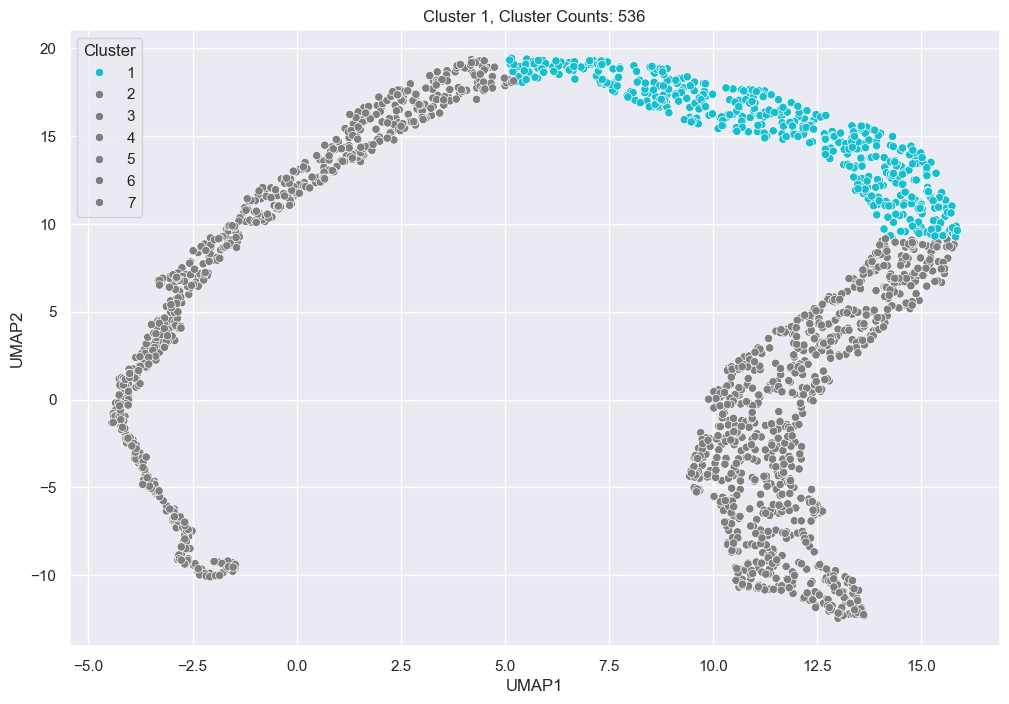

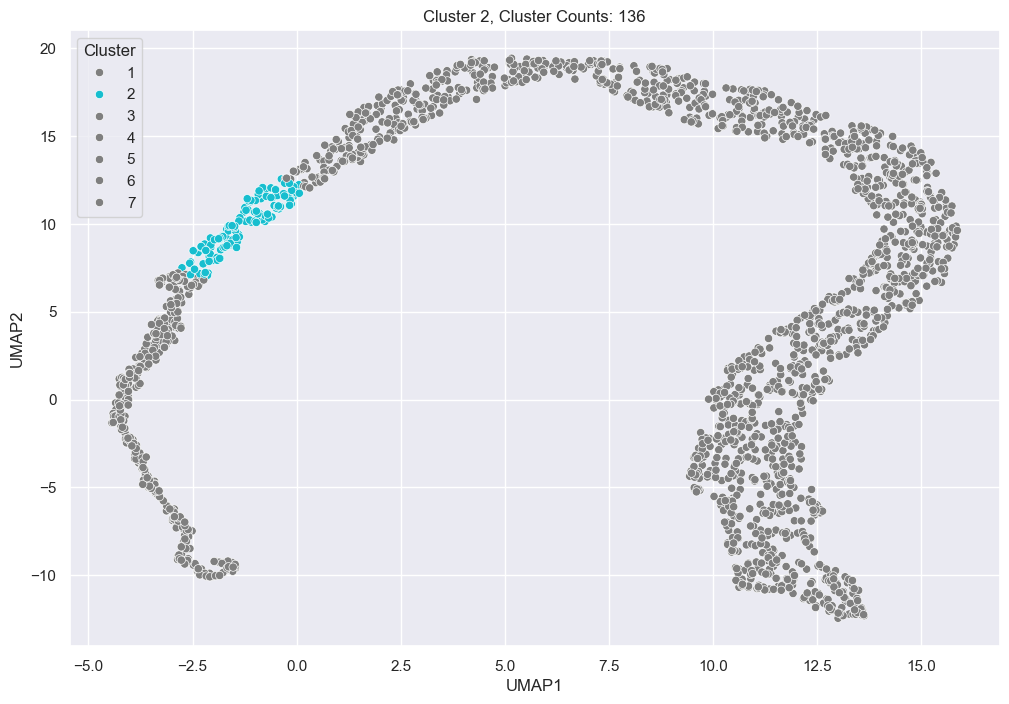

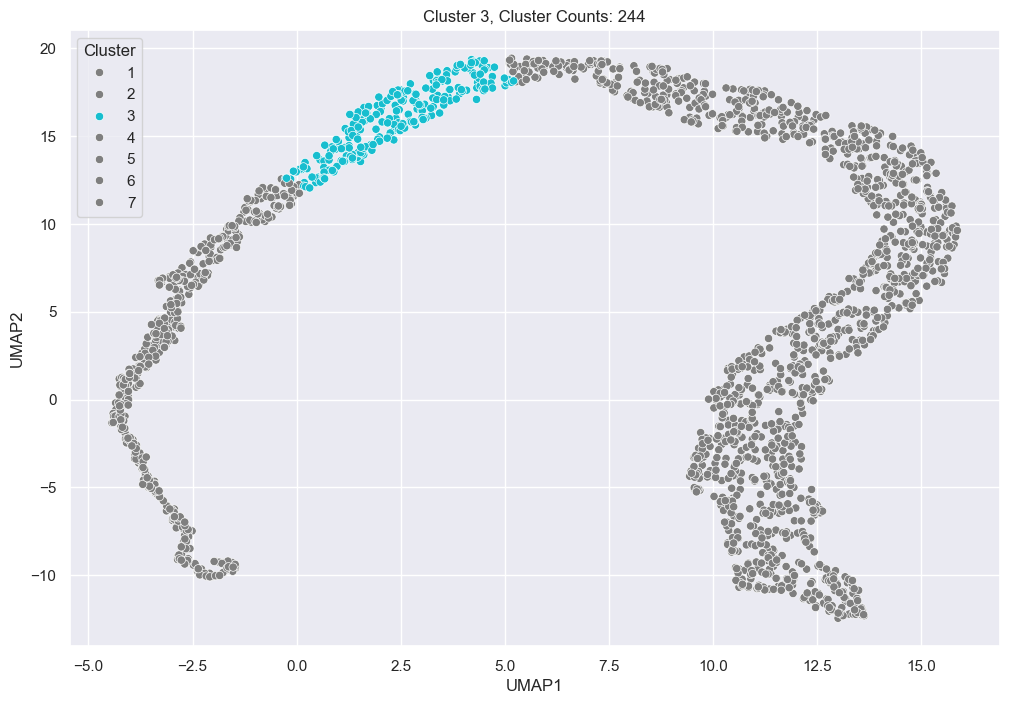

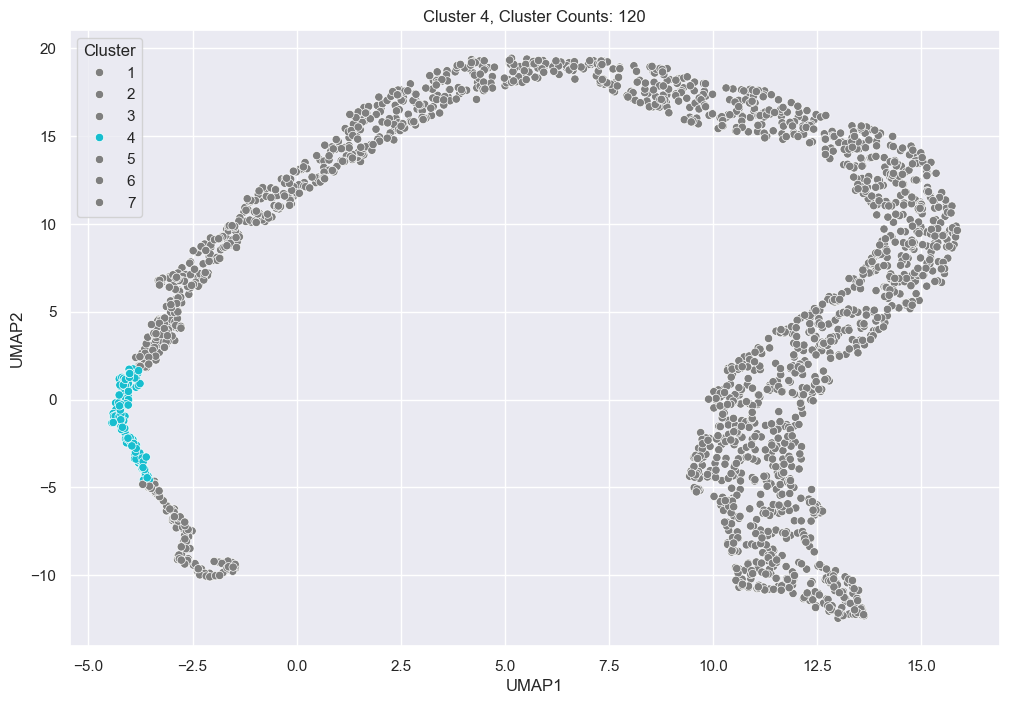

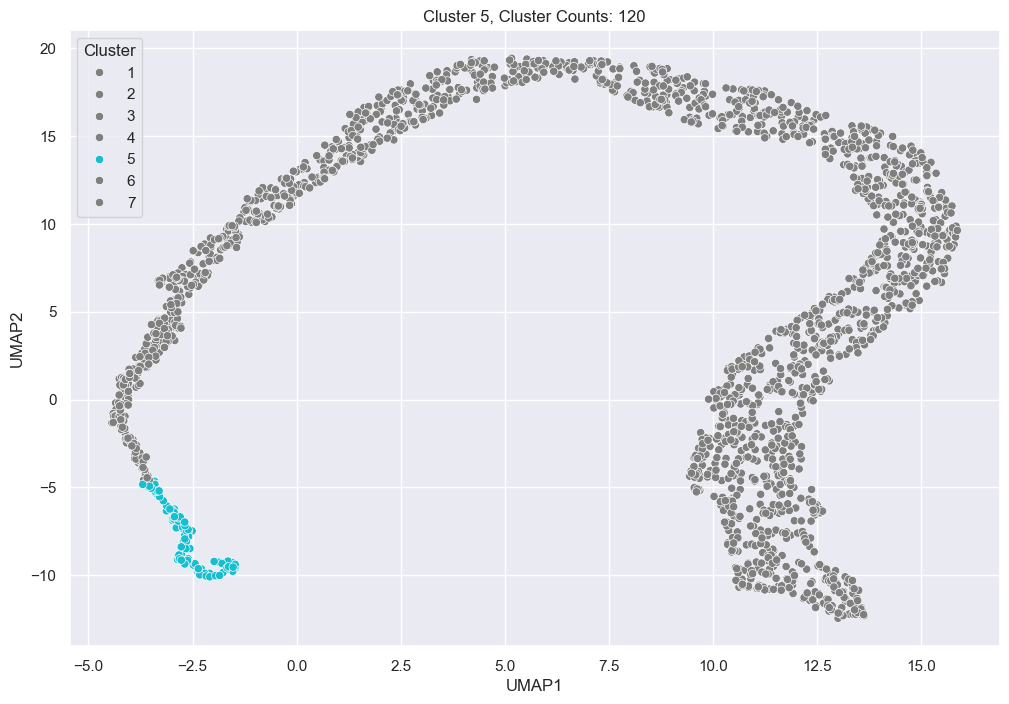

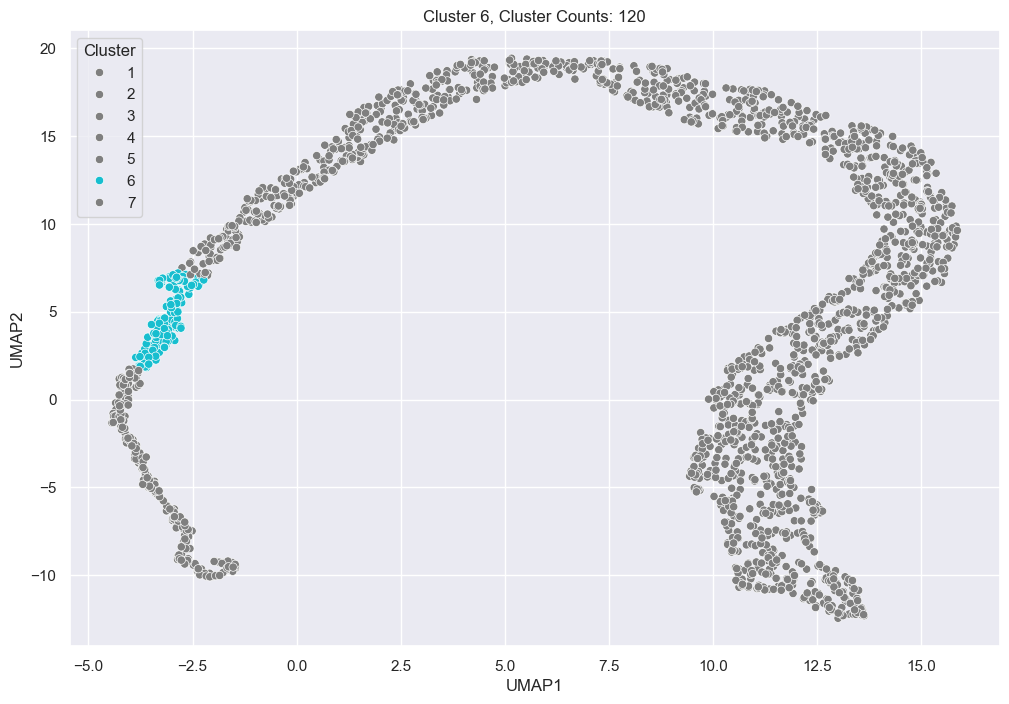

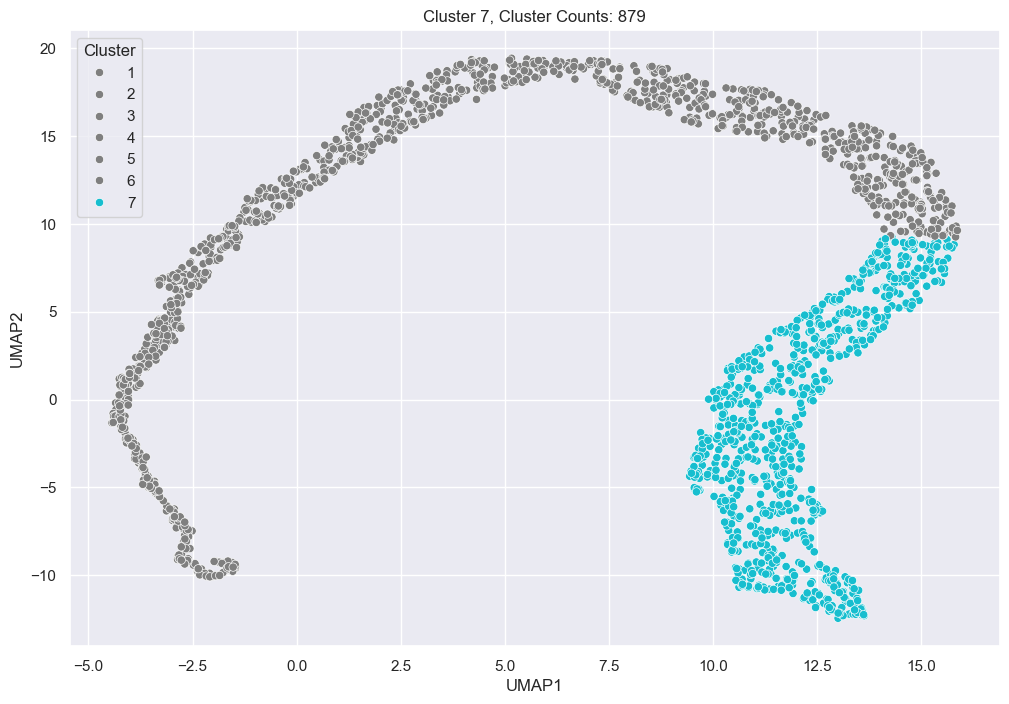

In [23]:
score, labels, cluster_counts = reduce_and_cluster(
    preprocessed_data, pca_params, kmeans_params, umap_params, use_constrained=True
)
print(f"Silhouette Score: {score}, Cluster Counts: {cluster_counts}")

# Cluster Statistics
Finally, we generate some descriptive statistics for each cluster as follows:

## Demographics:
**Top Countries:** (Brazil, 11.18%), (Germany, 12.09%), (USA, 13.78%)

**Top Cities:** (Sao Paulo, 4.55%), (México D.F., 4.81%), (London, 5.72%)

## Key Performance Indicators (KPIs):
**Average Monthly Spend:** $2561.09

**Customer Lifetime Value:** $92199.29

**Purchase Frequency:** 21.36 times per month

**Average Basket Size:** 11.63

## Purchase Trends:
**Top Product Categories:** (Confections, 16.38%), (Seafood, 17.95%), (Beverages, 24.45%)

In [13]:
data = pd.read_csv("customer_data.csv")

In [14]:
data["ClusterLabel"] = [x + 1 for x in labels]

order_dates = data["OrderDate"]
order_years = []
order_months = []
for i in range(data.shape[0]):
    date_obj = datetime.strptime(order_dates[i], "%Y-%m-%d")
    order_years.append(date_obj.year)
    order_months.append(date_obj.month)

data["OrderYear"] = order_years
data["OrderMonth"] = order_months

In [15]:
labels = np.unique(data["ClusterLabel"], return_counts=False)
clusters = []
for label in labels:
    clusters.append(data[data["ClusterLabel"] == label])

In [16]:
for label in labels:

    cluster = clusters[label - 1]
    print(f"# Cluster Analysis: Cluster {label}")
    print()

    print("## Demographics:")

    countries, country_counts = np.unique(
        cluster["CustomerCountry"], return_counts=True
    )
    idx = np.argpartition(country_counts, -3)[-3:]
    country_percentage = country_counts[idx] / np.sum(country_counts) * 100
    top_countries = zip(countries[idx], country_percentage)
    top_countries_formatted = [f"({x[0]}, {x[1]:.2f}%)" for x in top_countries]
    print(f"**Top Countries:** {', '.join(top_countries_formatted)}")

    cities, city_counts = np.unique(cluster["CustomerCity"], return_counts=True)
    idx = np.argpartition(city_counts, -3)[-3:]
    city_percentage = city_counts[idx] / np.sum(city_counts) * 100
    top_cities = zip(cities[idx], city_percentage)
    top_cities_formatted = [f"({x[0]}, {x[1]:.2f}%)" for x in top_cities]
    print(f"**Top Cities:** {', '.join(top_cities_formatted)}")
    print()

    print("## Key Performance Indicators (KPIs):")
    yearly_spend = []
    years = np.unique(cluster["OrderYear"])
    for year in years:
        yearly_spend.append(np.sum(cluster[cluster["OrderYear"] == year]["TotalPrice"]))
    monthly_spend = np.average(yearly_spend) / 12
    clf = np.sum(yearly_spend)
    purchase_freq = cluster.shape[0] / len(years) / 12
    basket_size = np.average(cluster["Quantity"])
    print(f"**Average Monthly Spend:** ${monthly_spend:.2f}")
    print(f"**Customer Lifetime Value:** ${clf:.2f}")
    print(f"**Purchase Frequency:** {purchase_freq:.2f} times per month")
    print(f"**Average Basket Size:** {basket_size:.2f}")
    print()

    print("## Purchase Trends:")
    categories, counts = np.unique(cluster["CategoryName"], return_counts=True)
    idx = np.argpartition(counts, -3)[-3:]
    category_percentage = counts[idx] / np.sum(counts) * 100
    top_categories = zip(categories[idx], category_percentage)
    top_categories_formatted = [f"({x[0]}, {x[1]:.2f}%)" for x in top_categories]
    print(f"**Top Product Categories:** {', '.join(top_categories_formatted)}")
    print()
    print("\n")

# Cluster Analysis: Cluster 1

## Demographics:
**Top Countries:** (Brazil, 7.69%), (USA, 13.55%), (Germany, 19.41%)
**Top Cities:** (München, 4.76%), (London, 5.49%), (Cunewalde, 5.49%)

## Key Performance Indicators (KPIs):
**Average Monthly Spend:** $4388.20
**Customer Lifetime Value:** $157975.20
**Purchase Frequency:** 7.58 times per month
**Average Basket Size:** 30.37

## Purchase Trends:
**Top Product Categories:** (Beverages, 14.29%), (Confections, 14.29%), (Dairy Products, 24.18%)



# Cluster Analysis: Cluster 2

## Demographics:
**Top Countries:** (Austria, 15.00%), (USA, 25.00%), (Germany, 16.67%)
**Top Cities:** (Boise, 10.83%), (Graz, 13.33%), (Cunewalde, 13.33%)

## Key Performance Indicators (KPIs):
**Average Monthly Spend:** $11360.51
**Customer Lifetime Value:** $408978.47
**Purchase Frequency:** 3.33 times per month
**Average Basket Size:** 55.55

## Purchase Trends:
**Top Product Categories:** (Beverages, 19.17%), (Meat/Poultry, 20.83%), (Dairy Products, 20.83%)




In [17]:
yearly_spend = []
years = np.unique(cluster["OrderYear"])
for year in years:
    yearly_spend.append(np.sum(data[data["OrderYear"] == year]["TotalPrice"]))
avg_monthly_spend = np.average(yearly_spend) / 12 / 7
print(f"avg_monthly_spend = {avg_monthly_spend}")

avg_monthly_spend = 5022.988251984127


In [18]:
avg_clf = np.sum(yearly_spend) / 7
print(f"avg_clf = {avg_clf}")

avg_clf = 180827.57707142856


In [19]:
avg_purchase_freq = data.shape[0] / len(years) / 12 / 7
print(f"avg_purchase_freq = {avg_purchase_freq}")

avg_purchase_freq = 8.551587301587302


In [20]:
avg_basket_size = np.average(data["Quantity"])
print(f"avg_basket_size = {avg_basket_size}")

avg_basket_size = 23.812993039443157
